In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chungkaichou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chungkaichou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chungkaichou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df=pd.read_csv('cleaned_data.csv',index_col=0)
df.head()

,airline,rating,nationality,Type Of Traveller,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Value For Money,Inflight Entertainment,Wifi & Connectivity,Recommended,trip_verified,review,flight_type,standardized_departure,standardized_arrival,Month,Year
0,ab-aviation,9,Netherlands,Solo Leisure,Economy Class,4.0,5.0,4.0,4.0,3.0,NaN,NaN,yes,1,pretty decent airline Moroni to Moheli. Turne...,Direct,Moroni,Moheli,November,2019.0
1,ab-aviation,1,United Kingdom,Solo Leisure,Economy Class,2.0,2.0,1.0,1.0,2.0,NaN,NaN,no,1,Not a good airline Moroni to Anjouan. It is a ...,Direct,Moroni,Anjouan,June,2019.0
2,ab-aviation,1,United Kingdom,Solo Leisure,Economy Class,2.0,1.0,1.0,1.0,2.0,NaN,NaN,no,1,flight was fortunately short Anjouan to Dzaou...,Direct,Anjouan,Dzaoudzi,June,2019.0
3,adria-airways,1,Serbia,Solo Leisure,Economy Class,1.0,1.0,NaN,1.0,1.0,NaN,NaN,no,0,I will never fly again with Adria Please do a...,Direct,Frankfurt,Pristina,September,2019.0
4,adria-airways,1,Netherlands,Couple Leisure,Economy Class,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no,1,it ruined our last days of holidays Do not boo...,Transit,Sofia,Amsterdam,September,2019.0


In [4]:
df.shape

(131906, 20)

In [5]:
df.dtypes

airline                    object
rating                     object
nationality                object
Type Of Traveller          object
Seat Type                  object
Seat Comfort              float64
Cabin Staff Service       float64
Food & Beverages          float64
Ground Service            float64
Value For Money           float64
Inflight Entertainment    float64
Wifi & Connectivity       float64
Recommended                object
trip_verified               int64
review                     object
flight_type                object
standardized_departure     object
standardized_arrival       object
Month                      object
Year                      float64
dtype: object

In [4]:
df['Year']=df['Year'].apply(lambda x:int(x) if pd.notna(x) else None)

In [5]:
df['trip_verified']=df['trip_verified'].astype(object)

In [6]:
df['rating']=df['rating'].apply(lambda x:int(x) if x.isdigit() else (None if x=='No rating' else np.nan))

In [7]:
df['rating'].value_counts()

rating
1.0     47139
10.0    14624
2.0     12641
9.0     12321
8.0     11452
3.0      7903
7.0      7412
5.0      5316
4.0      4759
6.0      4332
Name: count, dtype: int64

In [8]:
df['rating'].isna().sum()

4007

In [7]:
df.dropna(subset=['rating'],inplace=True)

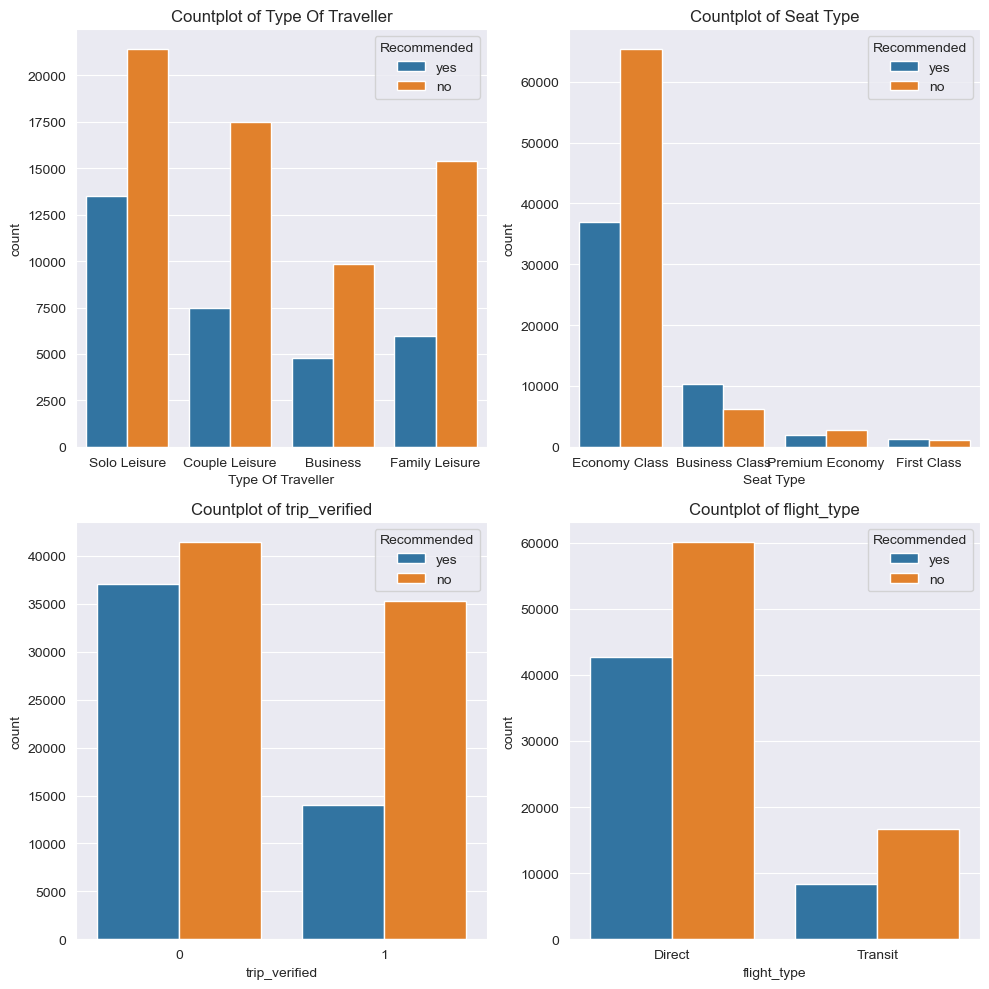

In [12]:
cate_cols=['Type Of Traveller','Seat Type','trip_verified','flight_type']
fig,axes =plt.subplots(2,2,figsize=(10,10))
axes=axes.flatten()
for ax,feature in zip(axes,cate_cols):
    sns.countplot(x=df[feature],hue=df['Recommended'],ax=ax)
    ax.set_title(f'Countplot of {feature}')
    ax.set_ylabel('count')
plt.tight_layout()
plt.show()

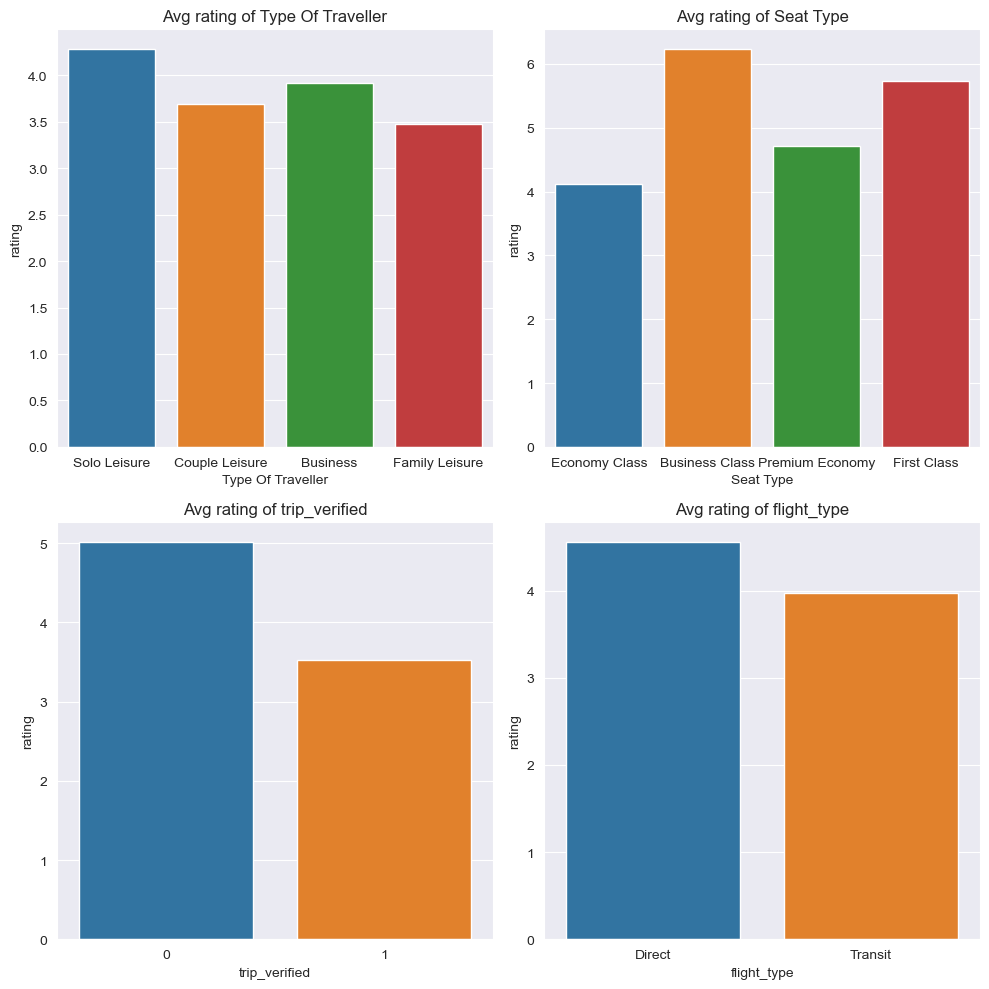

In [13]:
fig,axes =plt.subplots(2,2,figsize=(10,10))
axes=axes.flatten()
for ax,feature in zip(axes,cate_cols):
    sns.barplot(x=df[feature],y=df['rating'],estimator=np.mean,ax=ax,errorbar=None)
    ax.set_title(f'Avg rating of {feature}')
    ax.set_ylabel('rating')
plt.tight_layout()
plt.show()

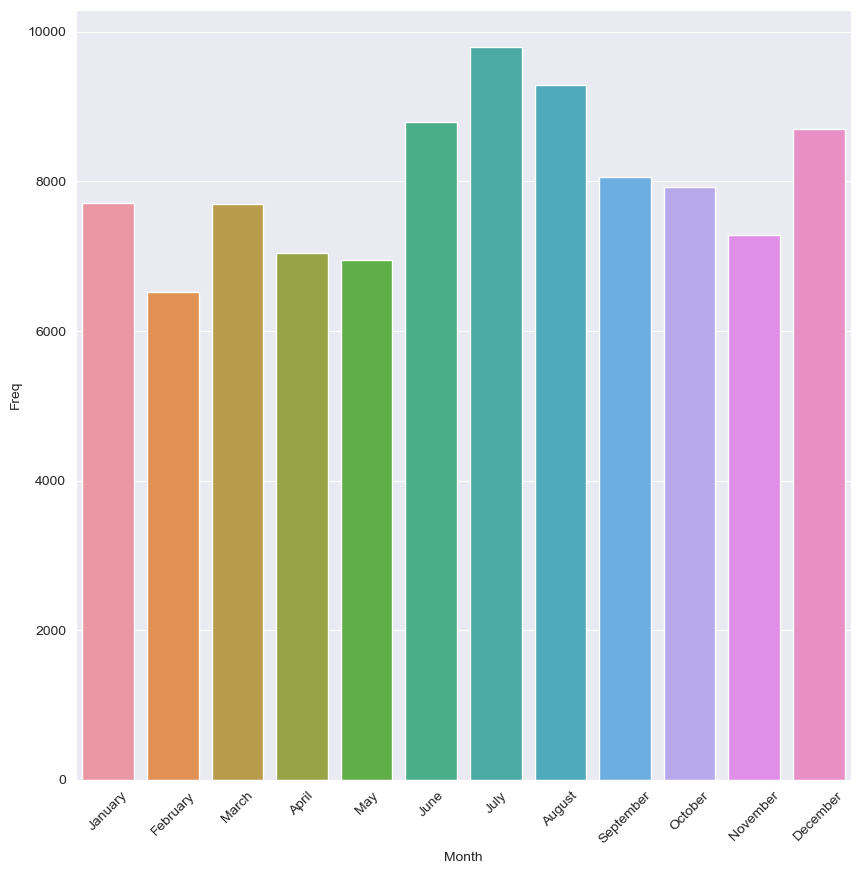

In [14]:
month_order=['January','February','March','April','May','June','July','August','September','October','November','December']
plt.figure(figsize=(10,10))
sns.countplot(x=df['Month'],order=month_order)
plt.xlabel('Month')
plt.ylabel('Freq')
plt.xticks(rotation=45)
plt.show()

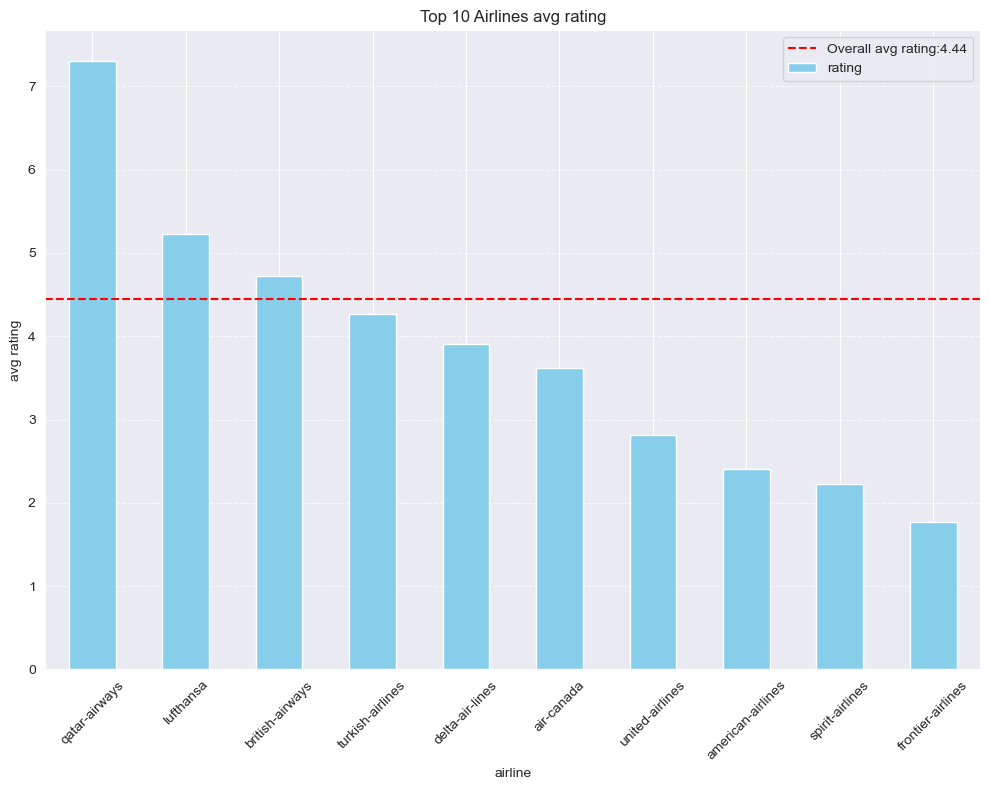

In [15]:
airline_vol=df.groupby('airline').size()
top10_airlines=airline_vol.nlargest(10).index
top10_airlines_df=df[df['airline'].isin(top10_airlines)]
avg_rating_top10=top10_airlines_df.groupby('airline')['rating'].mean().sort_values(ascending=False)
overall_avg_rating=df['rating'].mean()

plt.figure(figsize=(10,8))
avg_rating_top10.plot(kind='bar',color='skyblue')
plt.title('Top 10 Airlines avg rating')
plt.xlabel('airline')
plt.ylabel('avg rating')
plt.xticks(rotation=45)
plt.grid(axis='y',linestyle='--',alpha=0.7)

plt.axhline(overall_avg_rating,color='r',linestyle='--',label=f'Overall avg rating:{overall_avg_rating:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

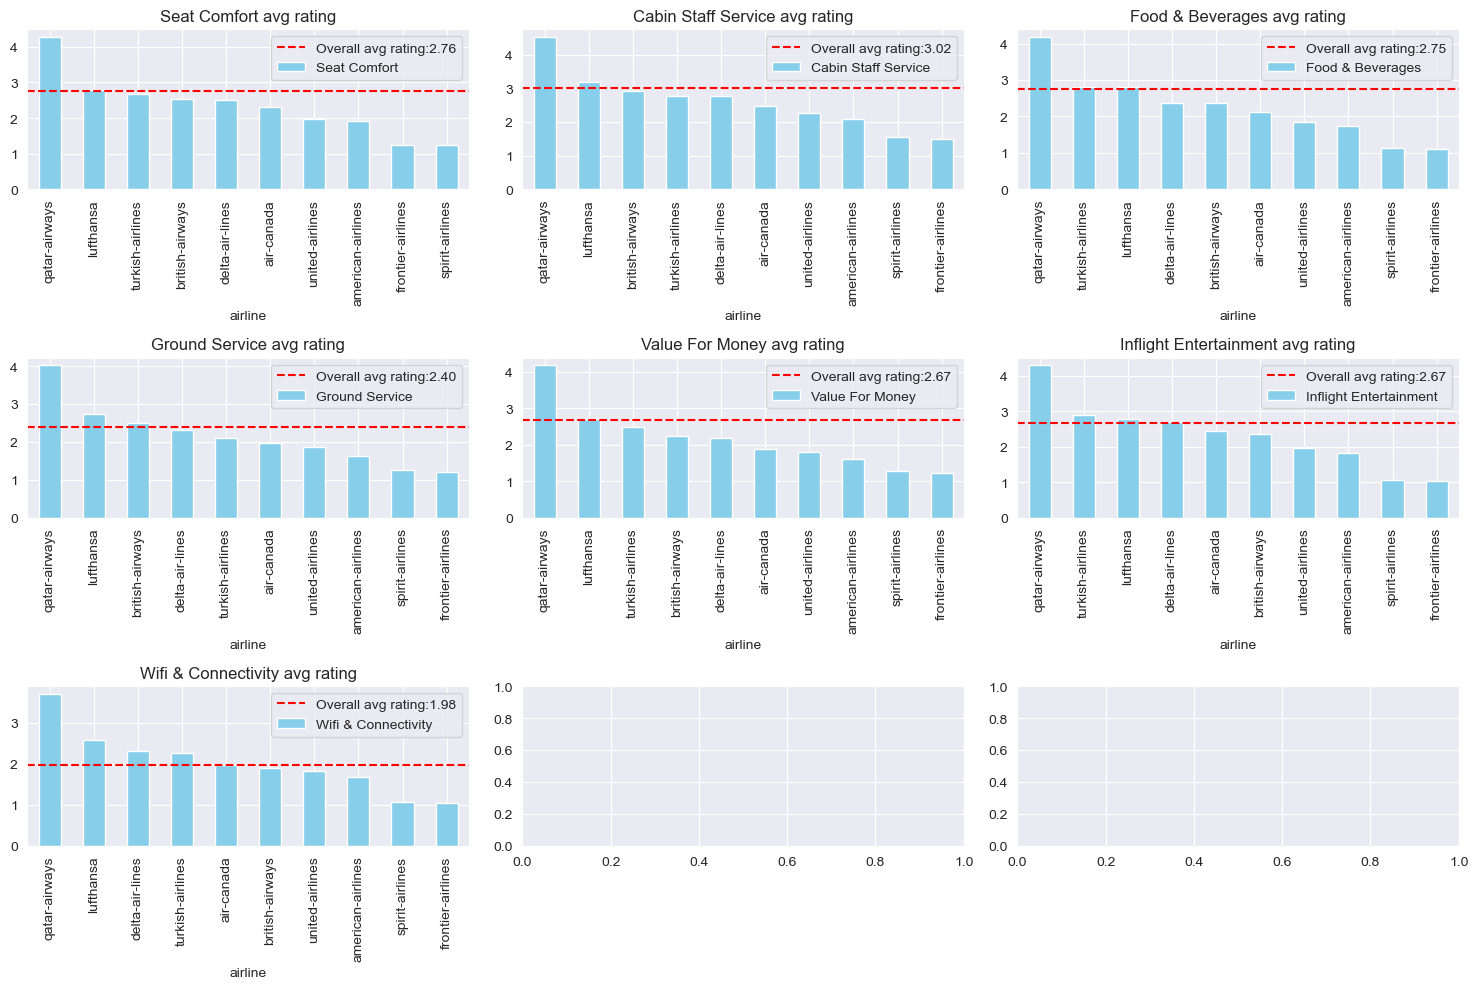

In [16]:
services=['Seat Comfort','Cabin Staff Service','Food & Beverages','Ground Service','Value For Money','Inflight Entertainment','Wifi & Connectivity']
service_data=top10_airlines_df[['airline']+services].copy()
service_data.dropna(subset=services,how='any',inplace=True)
overall_service=df[services].mean()
fig,axes=plt.subplots(3,3,figsize=(15,10))
axes=axes.flatten()

for idx,aspect in enumerate(services):
    avg_aspect_ratings=service_data.groupby('airline')[aspect].mean().sort_values(ascending=False)
    avg_aspect_ratings.plot(kind='bar',ax=axes[idx],color='skyblue',title=f'{aspect} avg rating')
    axes[idx].axhline(y=overall_service[aspect],color='r',linestyle='--',label=f'Overall avg rating:{overall_service[aspect]:.2f}')
    axes[idx].legend()
plt.tight_layout()
plt.show()

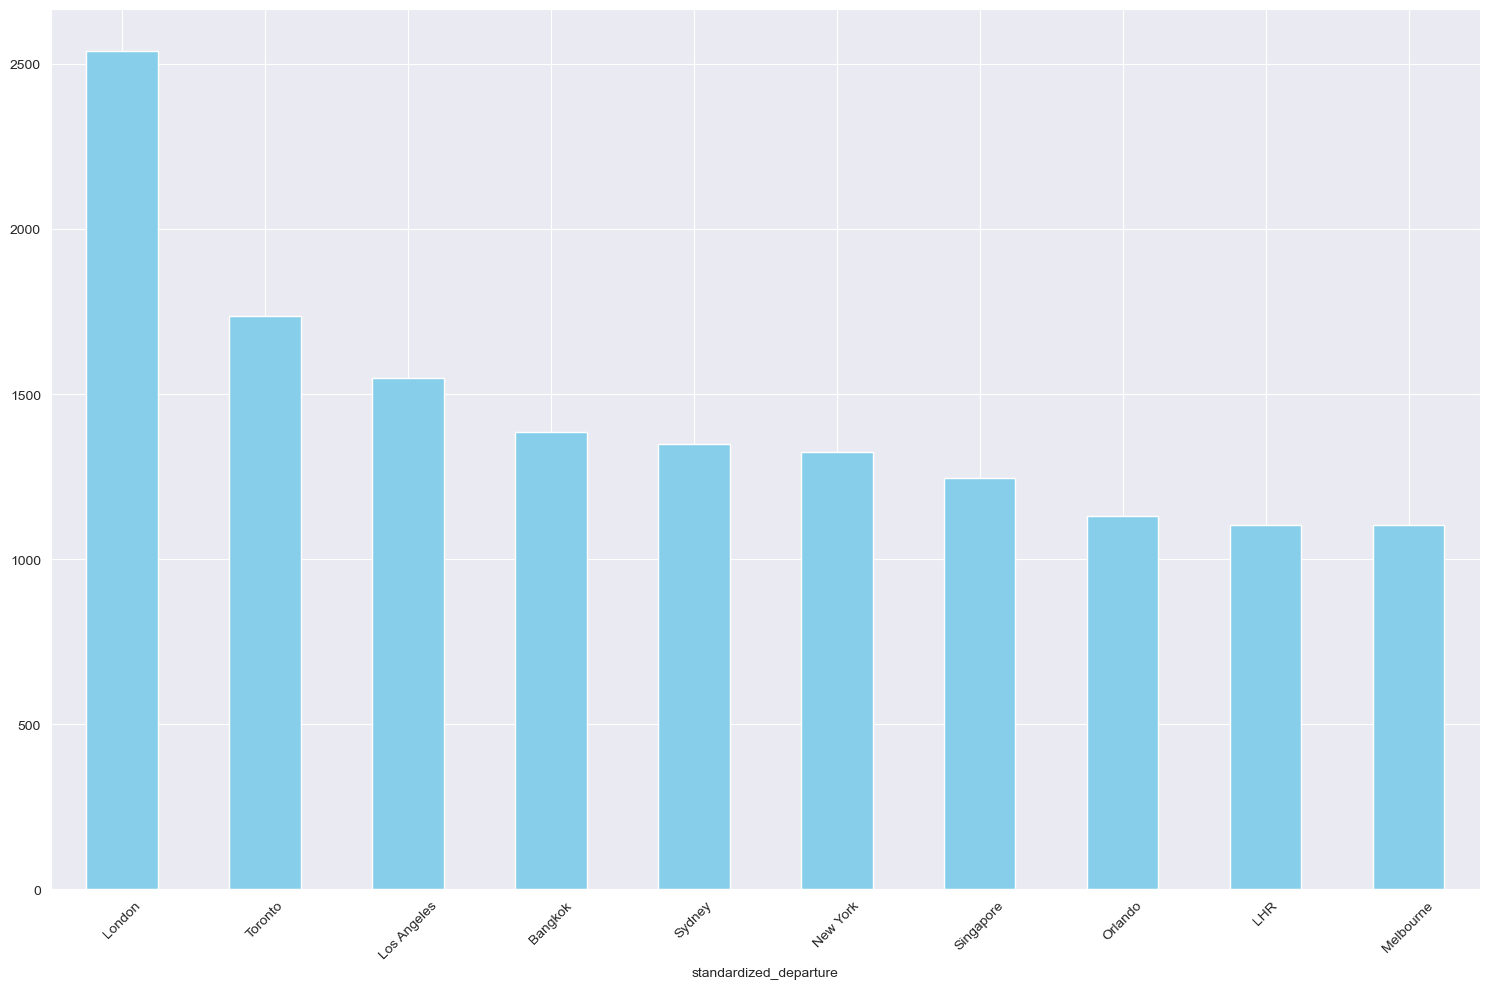

In [19]:
departing_count=df['standardized_departure'].value_counts()
top10_departure=departing_count.nlargest(10)
plt.figure(figsize=(15,10))
top10_departure.plot(kind='bar',color='skyblue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

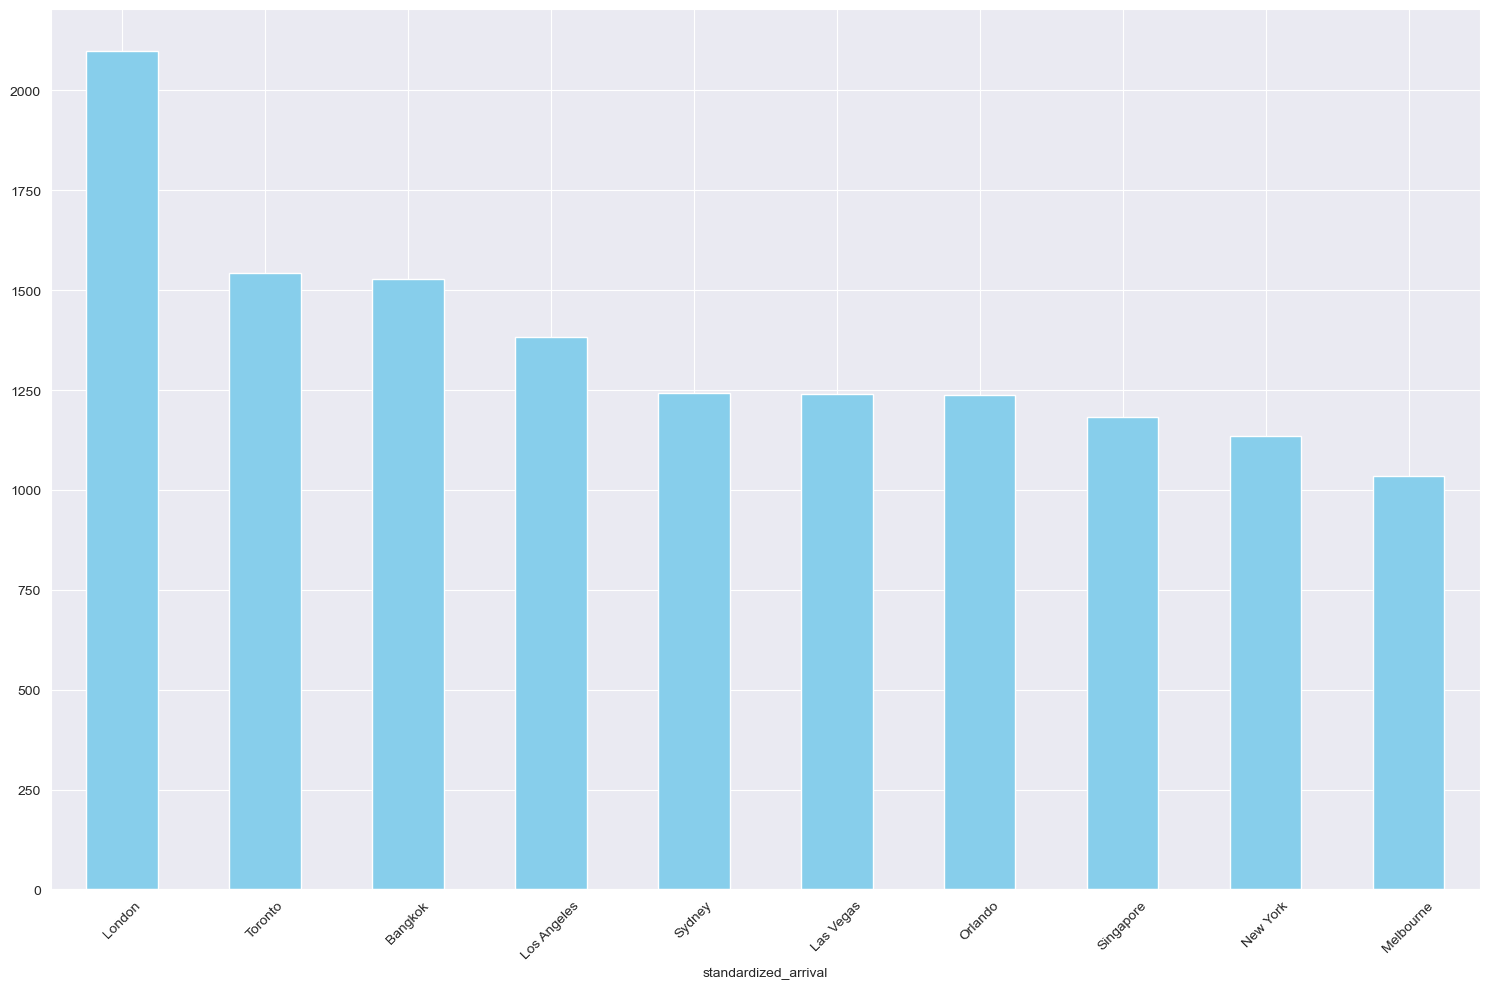

In [20]:

arriving_count = df['standardized_arrival'].value_counts()
top10_arrivial = arriving_count.nlargest(10)
plt.figure(figsize=(15, 10))
top10_arrivial.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

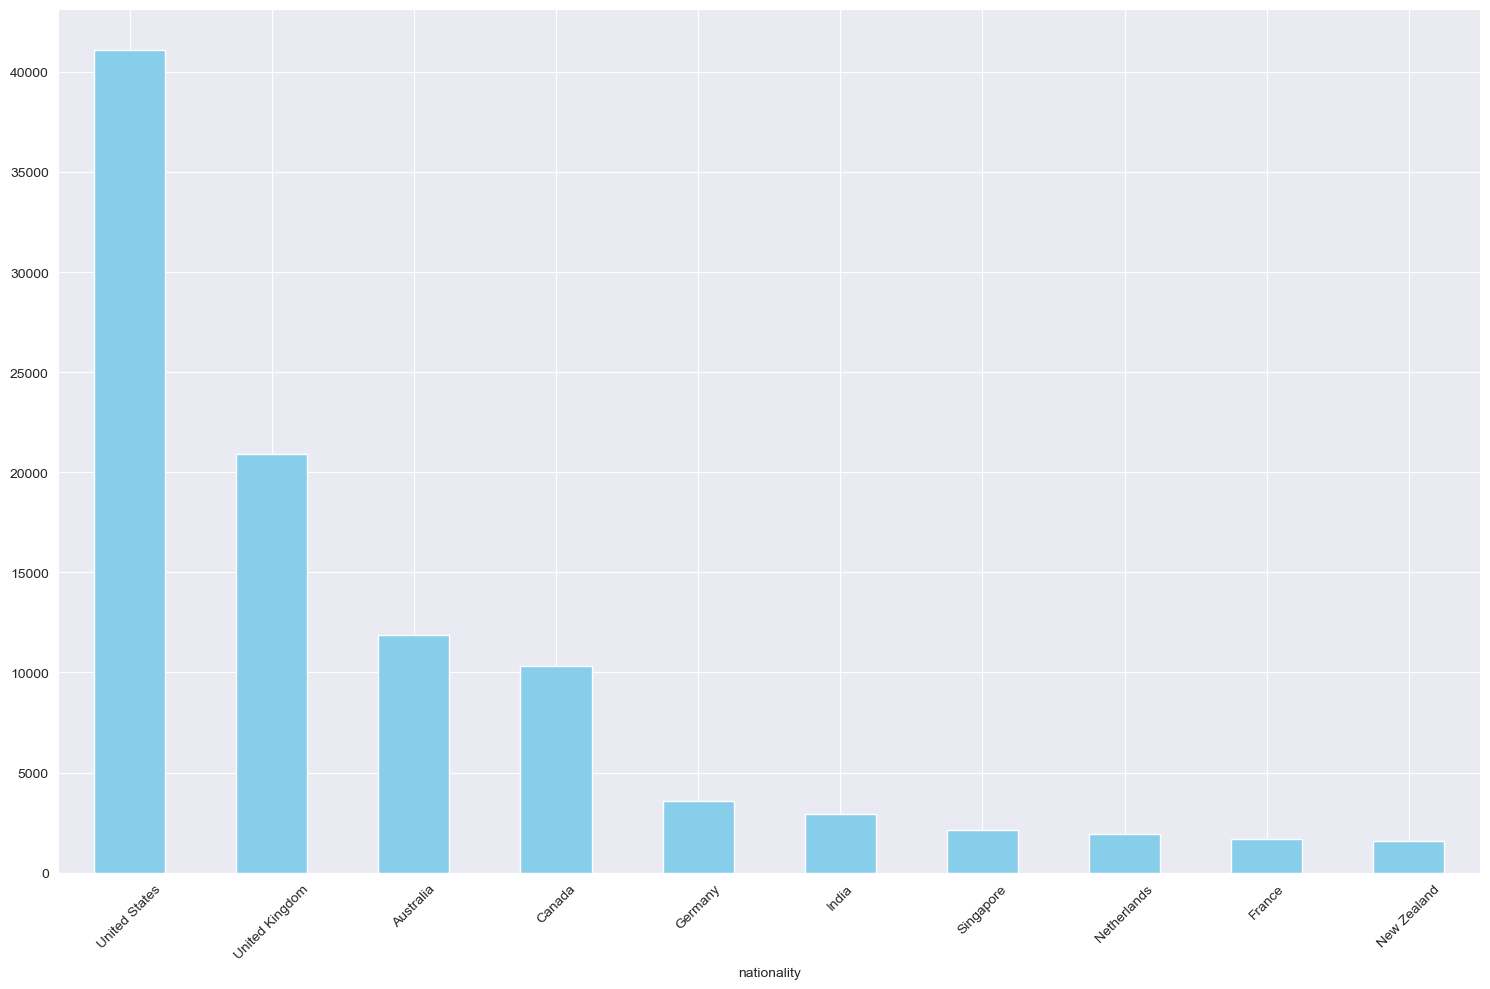

In [21]:
nationality_count=df['nationality'].value_counts()
top10_nationality=nationality_count.nlargest(10)
plt.figure(figsize=(15,10))
top10_nationality.plot(kind='bar',color='skyblue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
#statistic part
#correlation
df.dtypes

airline                    object
rating                    float64
nationality                object
Type Of Traveller          object
Seat Type                  object
Seat Comfort              float64
Cabin Staff Service       float64
Food & Beverages          float64
Ground Service            float64
Value For Money           float64
Inflight Entertainment    float64
Wifi & Connectivity       float64
Recommended                object
trip_verified              object
review                     object
flight_type                object
standardized_departure     object
standardized_arrival       object
Month                      object
Year                      float64
dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


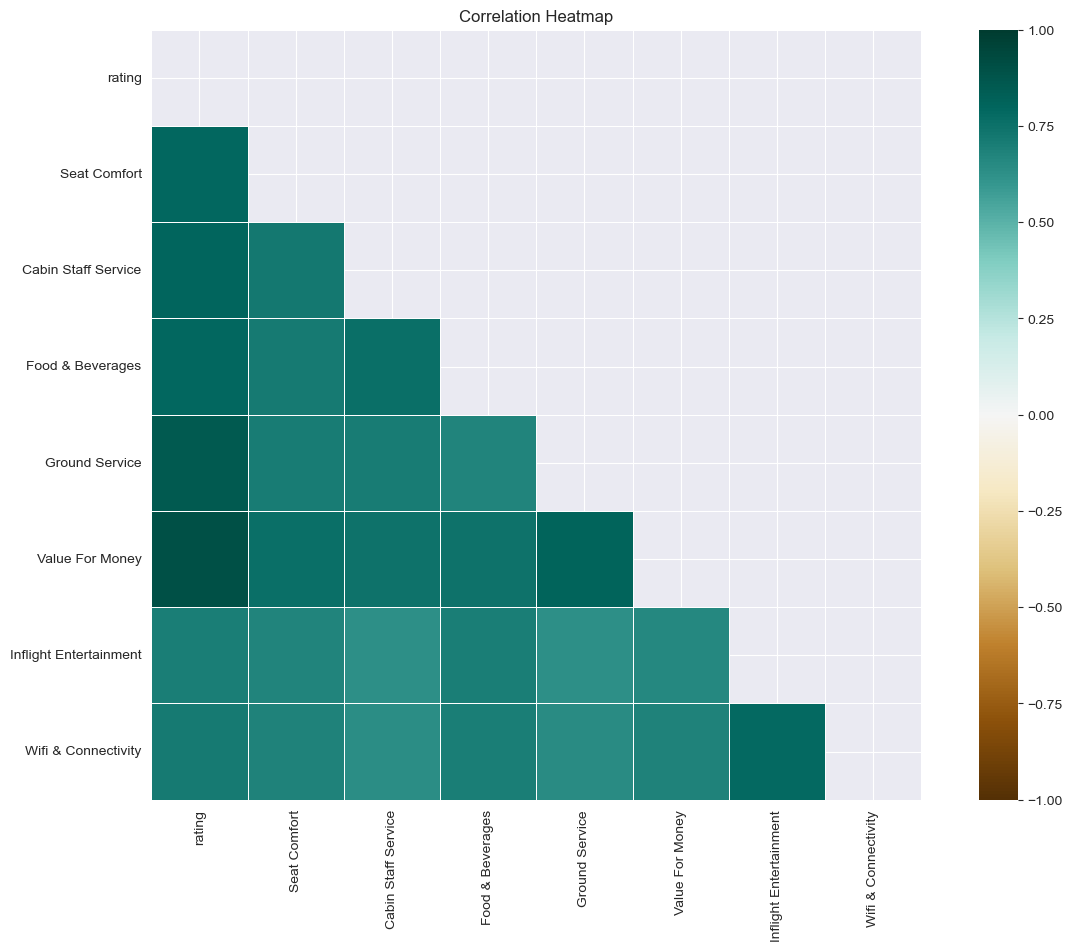

In [29]:
corre_col=['rating','Seat Comfort','Cabin Staff Service','Food & Beverages','Ground Service','Value For Money','Inflight Entertainment','Wifi & Connectivity']
corr=df[corre_col].corr()
plt.figure(figsize=(15,10))
mask=np.triu(np.ones_like(corr,dtype=bool))
sns.heatmap(corr, mask=mask,vmin=-1,vmax=1,cmap='BrBG',annot=True,fmt='.2f',square=True,linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

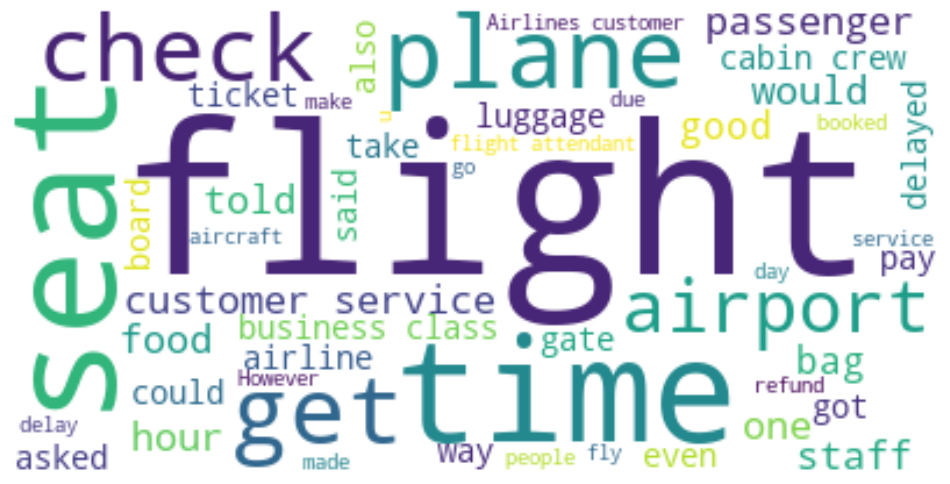

In [17]:
stop_words=set(stopwords.words('english'))
plt.figure(figsize=(12,10))
words=' '.join(df['review'])
wc=WordCloud(background_color='white',max_words=50,stopwords=stop_words)
wc.generate(words)
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()

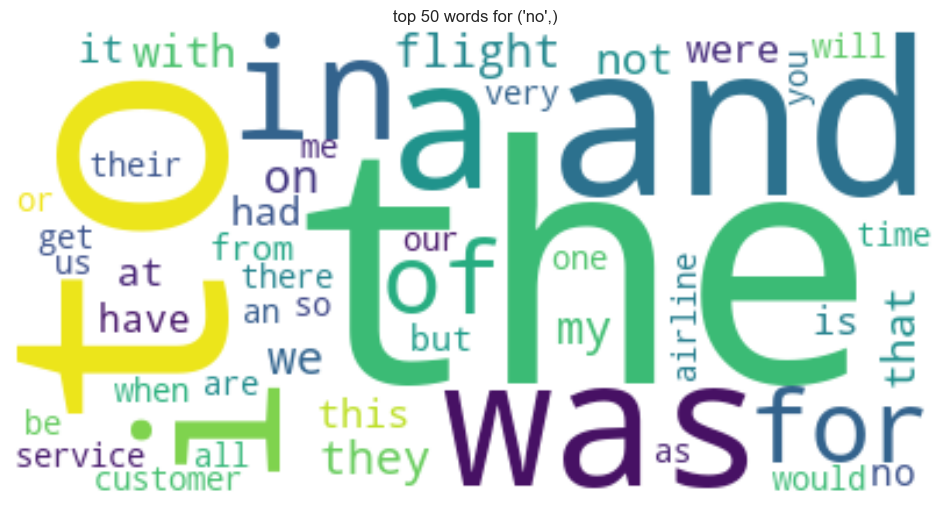

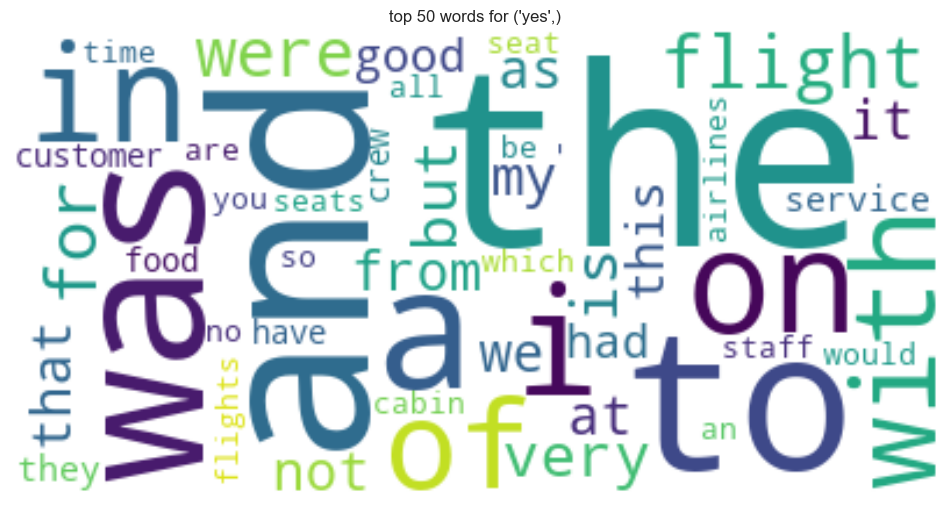

In [18]:
word_freq_by_recommendation={}
recommend_agg=df.groupby(['Recommended'])
for outcome,group in recommend_agg:
    combined=''.join(group['review']).lower()
    word_freq=pd.Series(combined.split()).value_counts()
    word_freq_by_recommendation[outcome]=word_freq
for outcome,freq in word_freq_by_recommendation.items():
    plt.figure(figsize=(12,10))
    wc=WordCloud(background_color='white',max_words=50,stopwords=stop_words)
    wc.generate_from_frequencies(freq)
    plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    plt.title(f'top 50 words for {outcome}')
    plt.show()

In [8]:
import string
lemmatizer = WordNetLemmatizer()
def text_preprocessor(text):
    text=re.sub(r'http[s]?://\S+', '', text)
    text=re.sub(r'@\w+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'\d+','',text)
    tokens = word_tokenize(text)
    tokens=[word.lower() for word in tokens]
    tokens=[word for word in tokens if word not in string.punctuation]
    
    stop_words = set(stopwords.words('english'))
    filted_tokens=[word for word in tokens if word not in stop_words]
    
    lemmatized_tokens=[lemmatizer.lemmatize(token) for token in filted_tokens]
    preprocessed_text=' '.join(lemmatized_tokens)
    return preprocessed_text

In [9]:
df['preprocessed_review']=df['review'].apply(text_preprocessor)
df['preprocessed_review'].head()

0    pretty decent airline moroni moheli turned pre...
1    good airline moroni anjouan small airline tick...
2    flight fortunately short anjouan dzaoudzi smal...
3    never fly adria please favor fly adria route m...
4    ruined last day holiday book flight airline fr...
Name: preprocessed_review, dtype: object

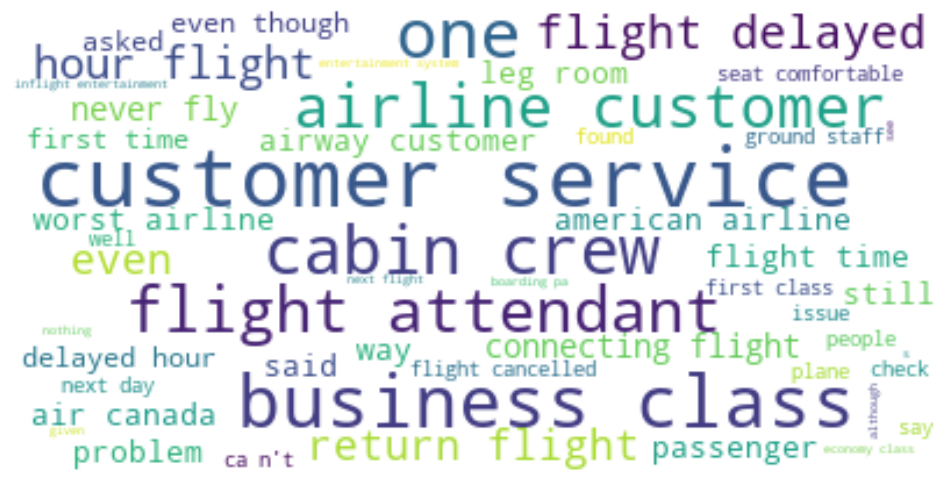

In [11]:
plt.figure(figsize=(12,10))
words=' '.join(df['preprocessed_review'])
wc=WordCloud(background_color='white',max_words=50,stopwords=STOPWORDS)
wc.generate(words)
plt.imshow(wc,interpolation='bilinear')

plt.axis("off")
plt.show()

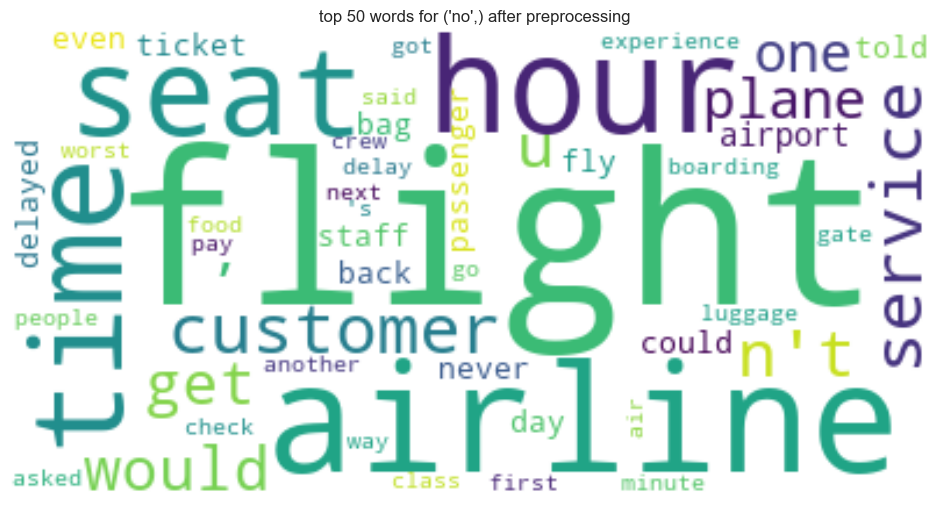

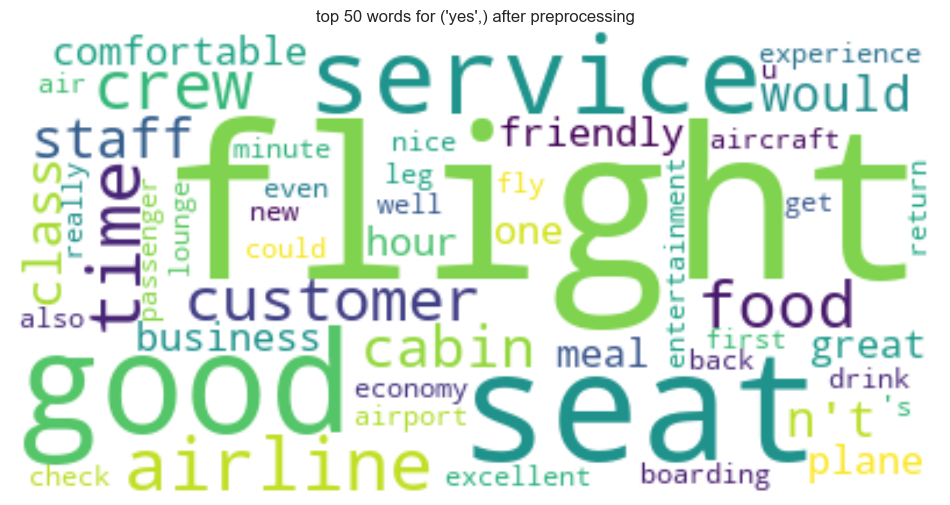

In [12]:
word_freq_by_recommendation={}
recommend_agg=df.groupby(['Recommended'])
for outcome,group in recommend_agg:
    combined=''.join(group['preprocessed_review']).lower()
    word_freq=pd.Series(combined.split()).value_counts()
    word_freq_by_recommendation[outcome]=word_freq
for outcome,freq in word_freq_by_recommendation.items():
    plt.figure(figsize=(12,10))
    wc=WordCloud(background_color='white',max_words=50,stopwords=STOPWORDS)
    wc.generate_from_frequencies(freq)
    plt.imshow(wc,interpolation='bilinear')
    plt.axis("off")
    plt.title(f'top 50 words for {outcome} after preprocessing')
    plt.show()